# Implementation of autoencoders

#### First, we will build three convolutional autoencoders, with different size of coding variables. Then, one fully connected autoencoder will be tried out. The model that has the best tradeoff between the loss and the size of coding variables, will be used in the classification task.

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
# Test connection and path to images
!ls "/gdrive/My Drive/computer-vision-project/dataset_resampled"

images	labels	segmentation


In [3]:
!python "/gdrive/My Drive/computer-vision-project/utils.py"

Using TensorFlow backend.


In [4]:
!pip install livelossplot

In [5]:
import keras
from keras import backend as K
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
from livelossplot import PlotLossesKeras
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


In [0]:
OPTIMIZER=keras.optimizers.RMSprop()
LOSS=keras.losses.mean_squared_error

In [0]:
exec(open('/gdrive/My Drive/computer-vision-project/utils.py').read())

In [0]:
PATH_TO_DATASET = "/gdrive/My Drive/computer-vision-project/dataset_resampled/"
PATH_TO_MODELS = "/gdrive/My Drive/computer-vision-project/models/"

Reading the images for training, validation and test.

In [0]:
x_train = read_train_images()
x_val = read_validation_images()
x_test = read_test_images()

In [0]:
y_train = read_train_labels()
y_val = read_validation_labels()
y_test = read_test_labels()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0 1]')

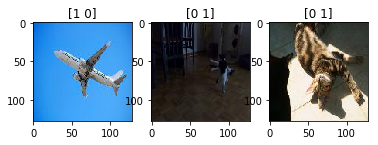

In [11]:
# Display the first image from training data
i=0
plt.subplot(131)
plt.imshow(x_train[i], cmap='gray')
plt.title(y_train[i])

# Display the first image from validation data
plt.subplot(132)
plt.imshow(x_val[i], cmap='gray')
plt.title(y_val[i])

# Display the first image from test data
plt.subplot(133)
plt.imshow(x_test[i], cmap='gray')
plt.title(y_test[i])

In [12]:
print("Training set (images) shape: {shape}".format(shape=x_train.shape))
print("Validation set (images) shape: {shape}".format(shape=x_val.shape))
print("Test set (images) shape: {shape}".format(shape=x_test.shape))

Training set (images) shape: (467, 128, 128, 3)
Validation set (images) shape: (386, 128, 128, 3)
Test set (images) shape: (97, 128, 128, 3)


In [13]:
print("Training set (labels) shape: {shape}".format(shape=y_train.shape))
print("Validation set (labels) shape: {shape}".format(shape=y_val.shape))
print("Test set (labels) shape: {shape}".format(shape=y_test.shape))

Training set (labels) shape: (467, 2)
Validation set (labels) shape: (386, 2)
Test set (labels) shape: (97, 2)


Verification the training and validation data types -> they should be float32.

In [14]:
x_train.dtype, x_val.dtype

(dtype('float32'), dtype('float32'))

Verification that the training and validation data are normalized.

In [15]:
np.max(x_train), np.max(x_val)

(1.0, 1.0)

Define hyperparameters

In [16]:
batch_size = 32    # batch_size = 64 yields larger loss
epochs = 50
inChannel = x_train.shape[3]
x, y = x_train.shape[1], x_train.shape[2]
input_img = Input(shape = (x, y, inChannel))

W0616 15:28:14.009069 139877886646144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 15:28:14.014330 139877886646144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



A Batch normalization was tried out - sfter each convolutiona layer, but it resulted in very high loss.

Define methods for calculation of the reconstruction error.

In [0]:
def get_mse_reconstruction_error(original, output):
  mse_reconstruction_error = mean_squared_error(original.flatten().reshape((original.shape[0],-1)), 
                                    output.flatten().reshape((output.shape[0],-1)))
  return mse_reconstruction_error

def get_mae_reconstruction_error(original, output):
  mae_reconstruction_error = mean_absolute_error(original.flatten().reshape((original.shape[0],-1)), 
                                    output.flatten().reshape((output.shape[0],-1)))
  return mae_reconstruction_error

## Autoencoder with 16 x 16 x 32 coding variables

In [0]:
def encoder(input_img):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)
    return conv4

def decoder(conv_layer):
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_layer) 
    up1 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv7) 
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2,2))(conv8) 
    decoded = Conv2D(inChannel, (3, 3), activation='sigmoid', padding='same')(up3) 
    return decoded

In [20]:
encoder = encoder(input_img)
print("Shape of code layer", K.int_shape(encoder))
autoencoder_16_16_32 = Model(input_img, decoder(encoder))
autoencoder_16_16_32.compile(loss=LOSS, optimizer = OPTIMIZER)

W0616 15:28:23.798330 139877886646144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 15:28:23.830638 139877886646144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0616 15:28:23.886003 139877886646144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0616 15:28:23.931930 139877886646144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Shape of code layer (None, 16, 16, 32)


In [21]:
autoencoder_16_16_32.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
__________

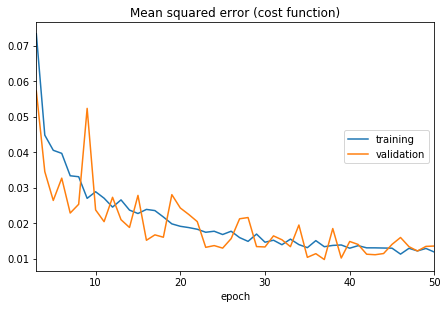

Mean squared error (cost function):
training   (min:    0.011, max:    0.101, cur:    0.012)
validation (min:    0.010, max:    0.274, cur:    0.014)


In [22]:
autoencoder_train_16_16_32 = autoencoder_16_16_32.fit(x_train, 
                                                      x_train, 
                                                      batch_size=batch_size,
                                                      epochs=epochs,
                                                      verbose=1,
                                                      validation_data=(x_val, x_val),
                                                      callbacks=[PlotLossesKeras()])

In [23]:
print('Loss: ' + str(np.mean(autoencoder_train_16_16_32.history['loss'])))
print('Validtion Loss: ' + str(np.mean(autoencoder_train_16_16_32.history['val_loss'])))


Loss: 0.023488528223776076
Validtion Loss: 0.026334292084808638


In [0]:
output_16_16_32 = autoencoder_16_16_32.predict(x_test)


In [25]:
print('MSE reconstruction error for Autoencoder_16_16_32 = %.5f' % get_mse_reconstruction_error(x_test, output_16_16_32))
print('MAE reconstruction error for Autoencoder_16_16_32 = %.5f' % get_mae_reconstruction_error(x_test, output_16_16_32))

MSE reconstruction error for Autoencoder_16_16_32 = 0.01335
MAE reconstruction error for Autoencoder_16_16_32 = 0.08692


## Autoencoder with 8 x 8 x 16 coding variables

In [0]:
def encoder(input_img):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3) 
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4) 
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool4) 
    return conv5

def decoder(conv_layer):
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_layer) 
    up1 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv7) 
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2,2))(conv8) 
    conv9 = Conv2D(256, (3, 3), activation='relu', padding='same')(up3)
    up4 = UpSampling2D((2,2))(conv9) 
    decoded = Conv2D(inChannel, (3, 3), activation='sigmoid', padding='same')(up4) 
    return decoded

In [27]:
encoder = encoder(input_img)
print("Shape of code layer", K.int_shape(encoder))
autoencoder_8_8_16 = Model(input_img, decoder(encoder))
autoencoder_8_8_16.compile(loss=LOSS, optimizer = OPTIMIZER)

Shape of code layer (None, 8, 8, 16)


In [28]:
autoencoder_8_8_16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
__________

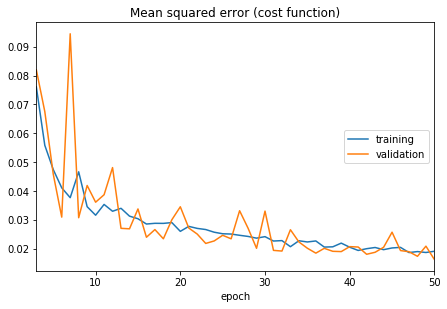

Mean squared error (cost function):
training   (min:    0.019, max:    0.082, cur:    0.019)
validation (min:    0.016, max:    0.094, cur:    0.016)


In [29]:
autoencoder_train_8_8_16 = autoencoder_8_8_16.fit(x_train, 
                                                      x_train, 
                                                      batch_size=batch_size,
                                                      epochs=epochs,
                                                      verbose=1,
                                                      validation_data=(x_val, x_val),
                                                      callbacks=[PlotLossesKeras()])

In [30]:
print('Loss: ' + str(np.mean(autoencoder_train_8_8_16.history['loss'])))
print('Validtion Loss: ' + str(np.mean(autoencoder_train_8_8_16.history['val_loss'])))


Loss: 0.029936480012421177
Validtion Loss: 0.030563971932755462


In [0]:
output_8_8_16 = autoencoder_8_8_16.predict(x_test)

In [32]:
print('MSE reconstruction error for Autoencoder_8_8_16 = %.5f' % get_mse_reconstruction_error(x_test, output_8_8_16))
print('MAE reconstruction error for Autoencoder_8_8_16 = %.5f' % get_mae_reconstruction_error(x_test, output_8_8_16))

MSE reconstruction error for Autoencoder_8_8_16 = 0.01409
MAE reconstruction error for Autoencoder_8_8_16 = 0.08264


## Autoencoder with 4 x 4 x 8 coding variables

In [0]:
def encoder(input_img):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3) 
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4) 
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool4) 
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5) 
    conv6 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool5) 
    return conv6

def decoder(conv_layer):
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_layer) 
    up1 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv7) 
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv8) 
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3) 
    up4 = UpSampling2D((2,2))(conv9) 
    conv10 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up5 = UpSampling2D((2,2))(conv10) 
    decoded = Conv2D(inChannel, (3, 3), activation='sigmoid', padding='same')(up5) 
    return decoded
    

In [34]:
encode = encoder(input_img)
print("Shape of code layer", K.int_shape(encode))
autoencoder_4_4_8 = Model(input_img, decoder(encode))
autoencoder_4_4_8.compile(loss=LOSS, optimizer=OPTIMIZER)
autoencoder_4_4_8.summary()

Shape of code layer (None, 4, 4, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 

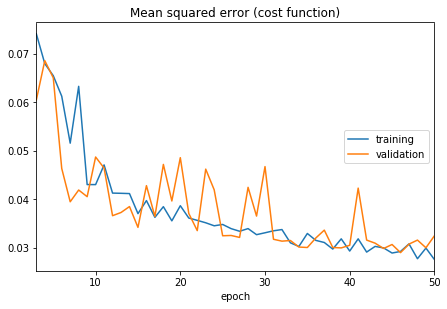

Mean squared error (cost function):
training   (min:    0.028, max:    0.081, cur:    0.028)
validation (min:    0.029, max:    0.071, cur:    0.032)


In [35]:
autoencoder_train_4_4_8 = autoencoder_4_4_8.fit(x_train, 
                                                  x_train, 
                                                  batch_size=batch_size,
                                                  epochs=50,
                                                  verbose=1,
                                                  validation_data=(x_val, x_val),
                                                  callbacks=[PlotLossesKeras()])

In [36]:
print('Loss: ' + str(np.mean(autoencoder_train_4_4_8.history['loss'])))
print('Validtion Loss: ' + str(np.mean(autoencoder_train_4_4_8.history['val_loss'])))

Loss: 0.03945124835789013
Validtion Loss: 0.03927798764056338


In [0]:
output_4_4_8 = autoencoder_4_4_8.predict(x_test)

In [38]:
print('MSE reconstruction error for Autoencoder_8_8_16 = %.5f' % get_mse_reconstruction_error(x_test, output_4_4_8))
print('MAE reconstruction error for Autoencoder_8_8_16 = %.5f' % get_mae_reconstruction_error(x_test, output_4_4_8))

MSE reconstruction error for Autoencoder_8_8_16 = 0.02970
MAE reconstruction error for Autoencoder_8_8_16 = 0.13596


## Deep autoencoder
- Fully connected layers
- Using flattened images
- Setting the encoding size: if the size is 32, we do a compression of factor 1536 (assuming flattend input image size of 49152)

In [0]:
x_resh = x_train[0].reshape(-1)
flaten_input = x_resh.shape
flat_input_img = Input(shape=flaten_input)
encoding_size = 256

In [0]:
x_train_flat = np.array([img.reshape(-1) for img in x_train])
x_val_flat = np.array([img.reshape(-1) for img in x_val])
x_test_flat = np.array([img.reshape(-1) for img in x_test])

In [0]:
def encoder(input_img):
  encoded = Dense(encoding_size*2, activation='relu')(input_img)
  encoded = Dense(encoding_size, activation='relu')(encoded)
  return encoded

def decoder(encoded):
  decoded = Dense(encoding_size*2, activation='relu')(encoded)
  decoded = Dense(flaten_input[0], activation='sigmoid')(decoded)
  return decoded

In [42]:
deep_encoder = encoder(flat_input_img)
autoencoder_deep = Model(flat_input_img, decoder(deep_encoder))
autoencoder_deep.compile(optimizer=OPTIMIZER, loss=LOSS)
autoencoder_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 49152)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               25166336  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 49152)             25214976  
Total params: 50,644,224
Trainable params: 50,644,224
Non-trainable params: 0
_________________________________________________________________


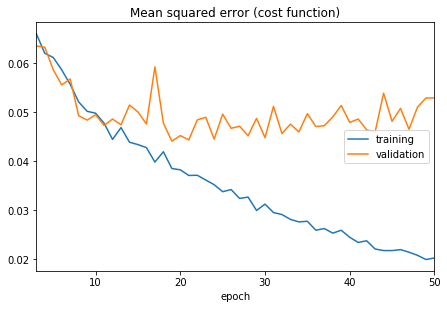

Mean squared error (cost function):
training   (min:    0.020, max:    0.115, cur:    0.020)
validation (min:    0.044, max:    0.072, cur:    0.053)


In [43]:
autoencoder_train_deep = autoencoder_deep.fit(x_train_flat, 
                                              x_train_flat,
                                              epochs=epochs,
                                              batch_size=batch_size,
                                              validation_data=(x_val_flat, x_val_flat),
                                              callbacks=[PlotLossesKeras()])

In [44]:
print('Loss: ' + str(np.mean(autoencoder_train_deep.history['loss'])))
print('Validtion Loss: ' + str(np.mean(autoencoder_train_deep.history['val_loss'])))

Loss: 0.037901581722517085
Validtion Loss: 0.05039982504602232


In [0]:
output_deep = autoencoder_deep.predict(x_test_flat)
output_deep_resh = output_deep.reshape(-1,x,y,inChannel)

In [46]:
print('MSE reconstruction error for Autoencoder_deep = %.5f' % get_mse_reconstruction_error(x_test, output_deep_resh))
print('MAE reconstruction error for Autoencoder_deep = %.5f' % get_mae_reconstruction_error(x_test, output_deep_resh))

MSE reconstruction error for Autoencoder_deep = 0.05027
MAE reconstruction error for Autoencoder_deep = 0.17208


#### Now, let's test how the autoencoders reconstruct the images.

In [0]:
def plot_reconstructed_images(i):
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(x_test[i], cmap='gray')
    plt.axis("off")
    plt.subplot(152)
    plt.title('16_16_32')
    plt.imshow(output_16_16_32[i], cmap='gray')
    plt.axis("off")
    plt.subplot(153)
    plt.title('8_8_16')
    plt.imshow(output_8_8_16[i], cmap='gray')
    plt.axis("off")
    plt.subplot(154)
    plt.title('4_4_8')
    plt.imshow(output_4_4_8[i], cmap='gray')
    plt.axis("off")
    plt.subplot(155)
    plt.title('FC AE')
    plt.imshow(output_deep_resh[i], cmap='gray')
    plt.axis("off")

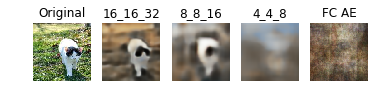

In [48]:
i = 20
plot_reconstructed_images(i)

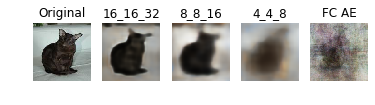

In [49]:
i = 15
plot_reconstructed_images(i)

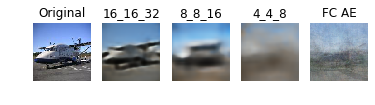

In [50]:
i = 35
plot_reconstructed_images(i)

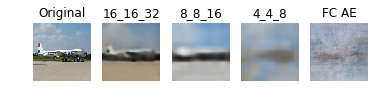

In [51]:
i = 25
plot_reconstructed_images(i)

In [52]:
save_model(autoencoder_16_16_32, 'autoencoder_16_16_32')

Saved model to disk


In [53]:
save_model(autoencoder_8_8_16, 'autoencoder_8_8_16')

Saved model to disk
